<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 200px; display: inline" alt="IMT"/> </a>
</center>

# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance d'Activité Humaine](https://github.com/wikistat/Ateliers-Big-Data/5-HumanActivityRecognition) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> 
##  Seconde partie:  étude des signaux bruts - Exploration

Ce notebook présente la partie exploratoire des données. Pour la prédiction, se référé au calepin suivant.

##  1 Introduction
### 1.1  Contexte
Les données sont issues de la communauté qui vise la reconnaissance d'activités humaines (*Human activity recognition, HAR*) à partir d’enregistrements, par exemple du gyroscope et de l'accéléromètre d'un smartphone, objet connecté précurseur et dont la fonctionnalité de téléphonie devient très secondaire.
Voir à ce propos l'[article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) relatant un colloque de 2013.  

Les données publiques disponibles et largement étudiées ont été acquises, décrites et analysées par [Anguita et al. (2013)]().
Elles sont accessibles sur le [dépôt](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) de l'University California Irvine (UCI) consacré à l'apprentissage machine ainsi que sur le site *Kaggle*.

L'archive contient les données brutes: accélérations en x, y, et z, chacun de 128 colonnes. D'autres fichiers en y soustrayant la gravité naturelle ainsi que les accélérations angulaires en x, y, et z soit en tout 9 fichiers. Mais 6 utiles avec 6*128=768 mesures.

C'est sur ces données brutes que nous allons appliquer des méthodes d'apprentissage

### 1.2 Objectifs
Cette deuxième étape s'intéresse aux données brutes. Est-il possible d'économiser le travail préliminaire de définition des variables métier en utilisant par exemple les ressources de décompositions systématiques sur une base d'ondelette ou un algorihtme d'apprentissage profond? L'enjeu est important, le calcul en temps réel des variables métier consomme beaucoup d'énergie et l'objectif serait de pouvoir embarquer (faire porter) un système économe défini par exemple par un réseau de neurones après son apprentissage.

Comme pour les données métier, l'étude commence par une exploration: affichage et visualisation des données, réduction de dimension.

### 1.3 Librairies

In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import random
import itertools

#Utils Sklearn
import sklearn.linear_model as lm
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()


import sklearn.decomposition as sdec 
import sklearn.preprocessing as sprep
import sklearn.discriminant_analysis as sda



## 2 Prise en charge des données
### 2.1 Source

Les données sont celles originales du dépôt de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Elle peuvent être téléchargées en cliquant [ici](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip).

Elles contiennent deux jeux de dimensions différentes, chacun partagé en apprentissage et test.

1. Multidimensionel: un individus est constitué de 9 Séries Temporelles de *dimensions* $(N, 128, 9)$
2. Unidimensionnel: Les 9 Séries Temporelles sont concaténées pour constituer un vecteur de $128*9 = 1152$ variables de *dimensions* $(N, 1152)$
        
Deux objets différents sont construits pour définir la variable $Y$ réponse car les librairies `Scikit-learn` et `Keras` prennent en compte des structures différentes: 
    
1. `Scikit-Learn`  Un vecteur de dimension $(N, 1)$ avec, pour chaque individu le numéro du label de l'activité de 0 à 5.
2. `Keras` Une matrice de dimension $(N, 6)$ des indicatrices (0 ou 1) des modalités de $Y$.

### 2.2 Structurer les données
Définir le chemin d'accès aux données puis les fonctions utiles.

In [2]:
DATADIR_UCI = './../data_har'
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]

def my_read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signal(data_dir, subset, signal):
    filename = f'{data_dir}/{subset}/Inertial Signals/{signal}_{subset}.txt'
    x = my_read_csv(filename).as_matrix()
    return x 

def load_signals(data_dir, subset, flatten = False):
    signals_data = []
    for signal in SIGNALS:
        signals_data.append(load_signal(data_dir, subset, signal)) 
    
    if flatten :
        X = np.hstack(signals_data)
    else:
        X = np.transpose(signals_data, (1, 2, 0))
        
    return X 

def load_y(data_dir, subset, dummies = False):
    filename = f'{data_dir}/{subset}/y_{subset}.txt'
    y = my_read_csv(filename)[0]
    
    
    if dummies:
        Y = pd.get_dummies(y).as_matrix()
    else:
        Y = y.as_matrix()
    
    return Y

Lecture des données

In [3]:
#Multidimensional Data
X_train, X_test = load_signals(DATADIR_UCI, 'train'), load_signals(DATADIR_UCI, 'test')
# Flattened Data
X_train_flatten, X_test_flatten = load_signals(DATADIR_UCI, 'train', flatten=True), load_signals(DATADIR_UCI, 'test', flatten=True)

# Label Y
Y_train_label, Y_test_label = load_y(DATADIR_UCI, 'train', dummies = False), load_y(DATADIR_UCI, 'test', dummies = False)
#Dummies Y (For Keras)
Y_train_dummies, Y_test_dummies = load_y(DATADIR_UCI, 'train', dummies = True), load_y(DATADIR_UCI, 'test', dummies = True)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

Vérification des dimensions

In [4]:
print("Dimension")
print("Données Multidimensionelles, : " + str(X_train.shape))
print("Données Unimensionelles, : " + str(X_train_flatten.shape))
print("Vecteur réponse (scikit-learn) : " + str(Y_train_label.shape))
print("Matrice réponse(Keras) : " + str(Y_train_dummies.shape))

Dimension
Données Multidimensionelles, : (7352, 128, 9)
Données Unimensionelles, : (7352, 1152)
Vecteur réponse (scikit-learn) : (7352,)
Matrice réponse(Keras) : (7352, 6)


## 3 Visualisations
### 3.1 Fonctions utiles

In [5]:
CMAP = plt.get_cmap("Accent")
SIGNALS = ["body_acc x", "body_acc y", "body_acc z", 
                "body_gyro x", "body_gyro y", "body_gyro z", 
               "total_acc x", "total_acc y", "total_acc z"] 


ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}

def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            ax.plot(x, linewidth=1, color=cmap(act-1))

            
def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
    plot_data = []
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            plot_data.append([x,cmap(act-1)])
    random.shuffle(plot_data)
    for x,color in plot_data:
        ax.plot(x, linewidth=1, color=color)

### 3.2 Tous les signaux

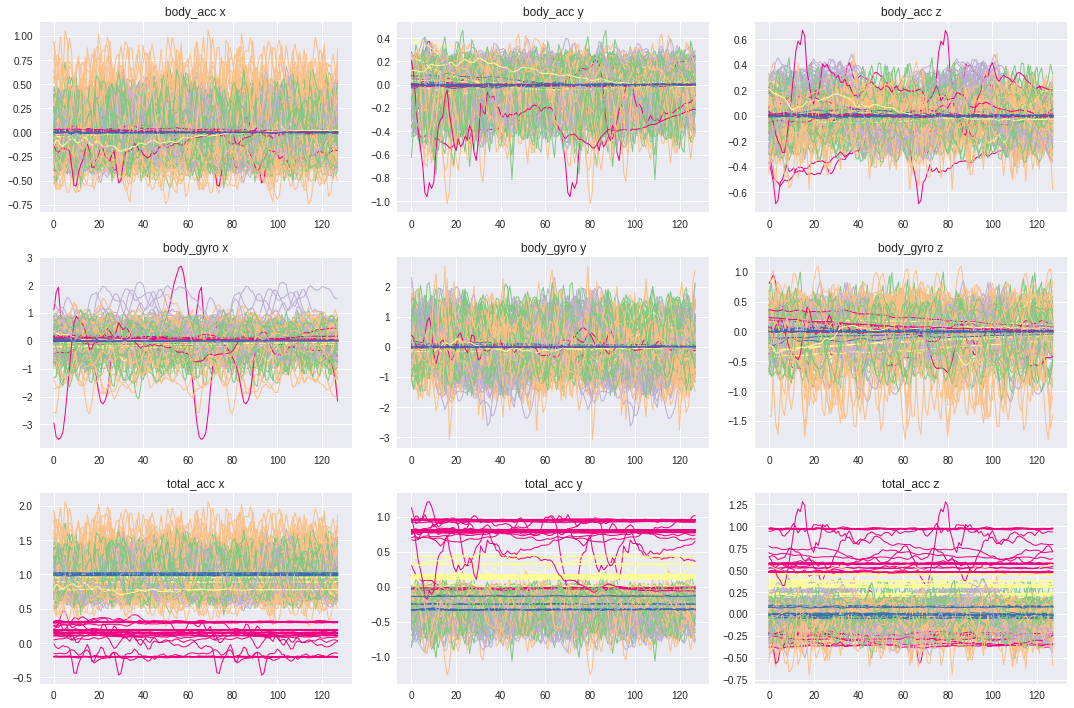

In [6]:
sample_to_plot = 50
index_per_act = [list(zip(np.repeat(act, sample_to_plot), np.where(Y_train_label==act)[0][:sample_to_plot])) for act in range(1,7)]
index_to_plot = list(itertools.chain.from_iterable(index_per_act))
random.shuffle(index_to_plot)

fig = plt.figure(figsize=(15,10))
for isignal in range(9):
    ax = fig.add_subplot(3,3,isignal+1)
    for act , i in index_to_plot:
        ax.plot(range(128), X_train[i,:,isignal],color=CMAP(act-1), linewidth=1)
        ax.set_title(SIGNALS[isignal])
plt.tight_layout()

### 3.3 Par signal 

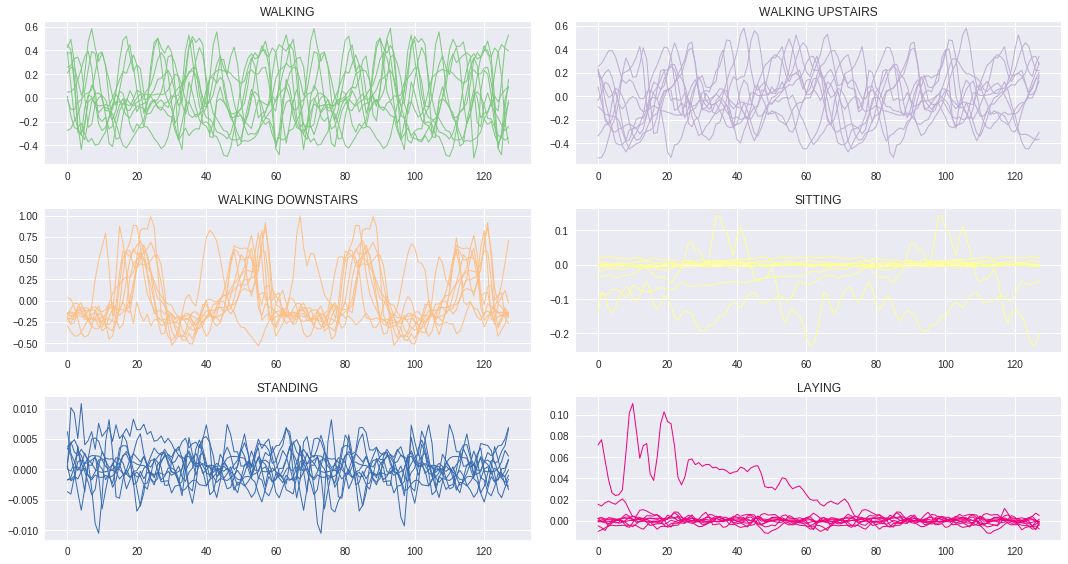

In [8]:
sample_to_plot = 10
#isignal correspond à une série temporelle (varie de 1 à 9)
isignal = 1
index_per_act_dict = dict([(act, np.where(Y_train_label==act)[0][:sample_to_plot]) for act in range(1,7)])


fig = plt.figure(figsize=(15,8), num=SIGNALS[isignal])
for act , index in index_per_act_dict.items():
    ax = fig.add_subplot(3,2,act)
    for x in X_train[index]:
        ax.plot(range(128), x[:,0],color=CMAP(act-1), linewidth=1)
    ax.set_title(ACTIVITY_DIC[act])
plt.tight_layout()

**Q** Observer l'un des signaux, par exemple `Walking upstairs`. Qu'est ce qui fait que, pour ces signaux ou courbes, une métrique euclidienne classique ($L_2$) est inopérante?   
Une métrique euclidienne est inopérante car deux courbes identiques mais translatées seront détectées comme totalement différentes, même si elles sont attribuées à la même activité. 

**Q** Corrélativement pourquoi est-il intéressant de décomposer un signal dans le domaine des fréquences?   
Dans le domaine des fréquences, la périodicité est prise en compte : plus la période est petite plus la fréquence est grande. Ainsi, deux signaux de périodicité très proche seront corrélés dans le domaine des fréquences. Par exemple, walking upstairs et walking ont même amplitude, mais peuvent potentiellement être différenciées par leurs périodes. Ainsi, les translations ne sont plus un objet de différenciation de deux signaux ayant par ailleurs même période. 

In [9]:
def plot_pca(X_R, ytrain, fig, ax, nbc, nbc2, label_dic=ACTIVITY_DIC, cmaps = plt.get_cmap("Accent")
):
    for i in range(6):
        xs = X_R[ytrain==i+1,nbc-1]
        ys = X_R[ytrain==i+1, nbc2-1]
        label = label_dic[i+1]
        color = cmaps(i)
        ax.scatter(xs, ys, color=color, alpha=.8, s=10, label=label)
        ax.set_xlabel("PC%d : %.2f %%" %(nbc,pca.explained_variance_ratio_[nbc-1]*100), fontsize=15)
        ax.set_ylabel("PC%d : %.2f %%" %(nbc2,pca.explained_variance_ratio_[nbc2-1]*100), fontsize=15)


## 4 Analyse en composantes principales
### 4.1 Sur un Signal

In [32]:
pca = sdec.PCA()
isignal = 4
signal = SIGNALS[isignal]
print("ACP Sur signal : " +signal)
X_r = pca.fit_transform(X_train[:,:,isignal])


ACP Sur signal : body_gyro y


(7352, 128)

Text(0.5,0.98,'Résultat ACP sur Signal : body_gyro y')

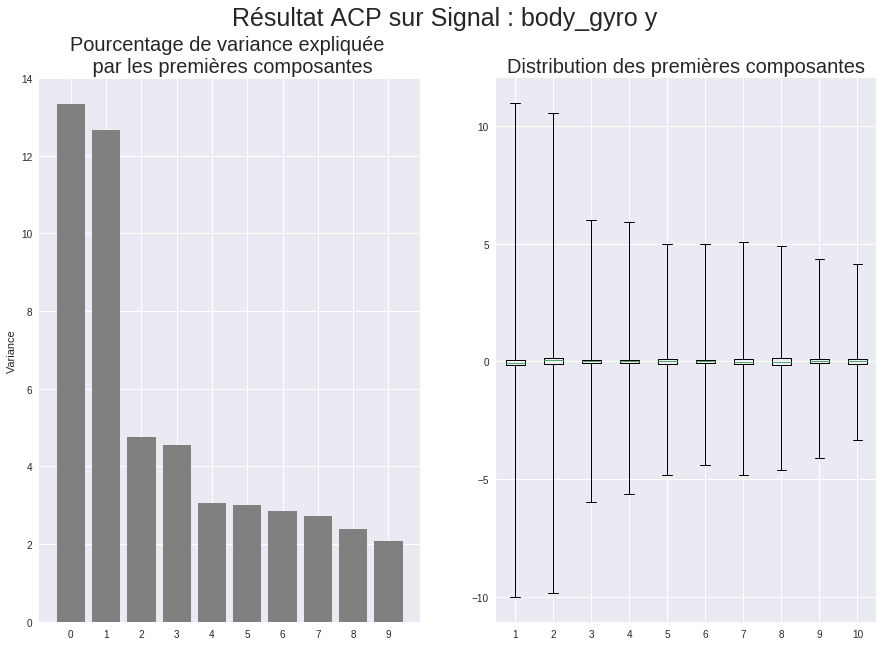

In [11]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title("Pourcentage de variance expliquée \n par les premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_r[:,0:10],whis=100)
ax.set_title("Distribution des premières composantes", fontsize=20)

fig.suptitle("Résultat ACP sur Signal : " + signal, fontsize=25)

**Attention**: les diagrammes boîtes sont très perturbés pas les distributions des composantes avec une très forte concentration autour de 0 et énormément de valeurs atypiques. D'où l'utilisation du paramètre `whis=100` pour rallonger les moustaches.

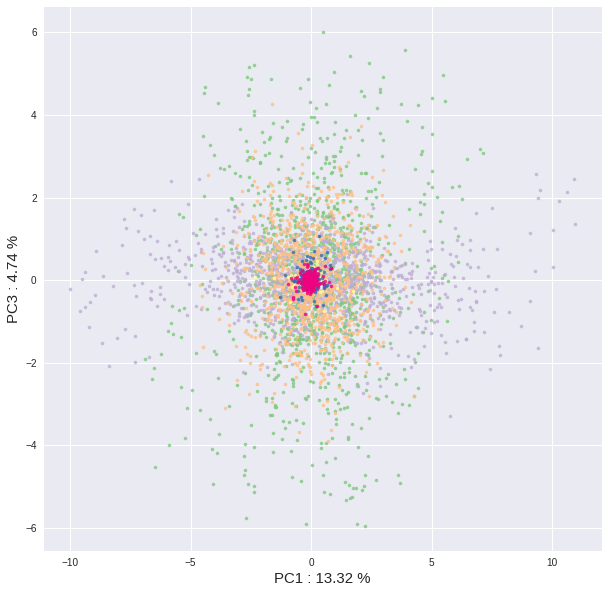

In [17]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r, Y_train_label,fig ,ax ,1 ,3)

#### Avec les données réduites

In [63]:
print("ACP Sur signal : " +signal)
scaler = sprep.StandardScaler(with_mean=False)
X_train_std=scaler.fit_transform(X_train[:,:,isignal])
X_r_std = pca.fit_transform(X_train_std)
X_r_std = pca.fit_transform(sprep.scale(X_train[:,:,isignal],with_mean=False))

ACP Sur signal : body_acc x


Text(0.5,0.98,'Résultat ACP sur tous les signaux')

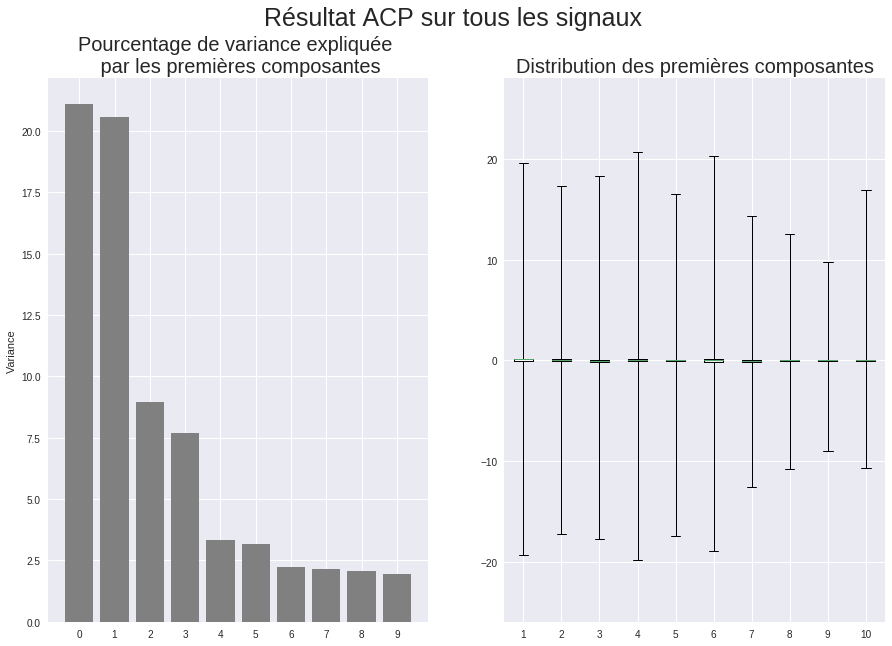

In [64]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title("Pourcentage de variance expliquée \n par les premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_r_std[:,0:10],whis=100)
ax.set_title("Distribution des premières composantes", fontsize=20)

fig.suptitle("Résultat ACP sur tous les signaux", fontsize=25)

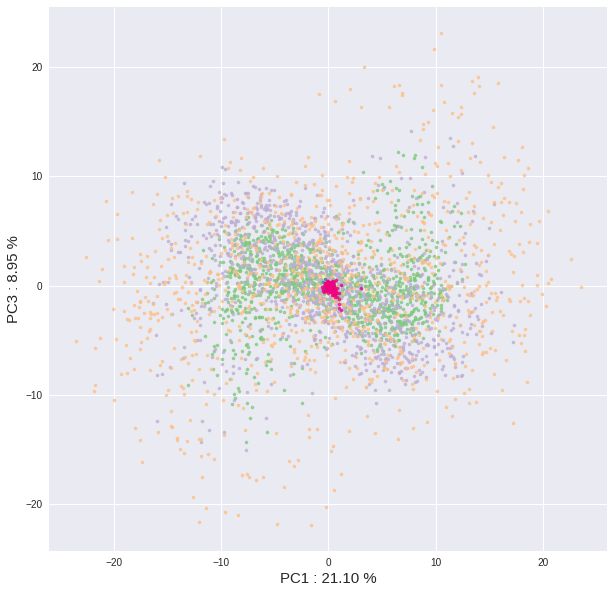

In [65]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r_std, Y_train_label,fig ,ax ,1 ,3)

La réduction de la matrice au préalable n'apporte pas d'amélioration à l'ACP. 

### 4.2 Sur tous les signaux

In [54]:
pca = sdec.PCA()
print("ACP Sur tous les signaux")
X_r = pca.fit_transform(X_train_flatten)

ACP Sur tous les signaux


(7352, 1152)

Text(0.5,0.98,'Résultat ACP tous les signaux : ')

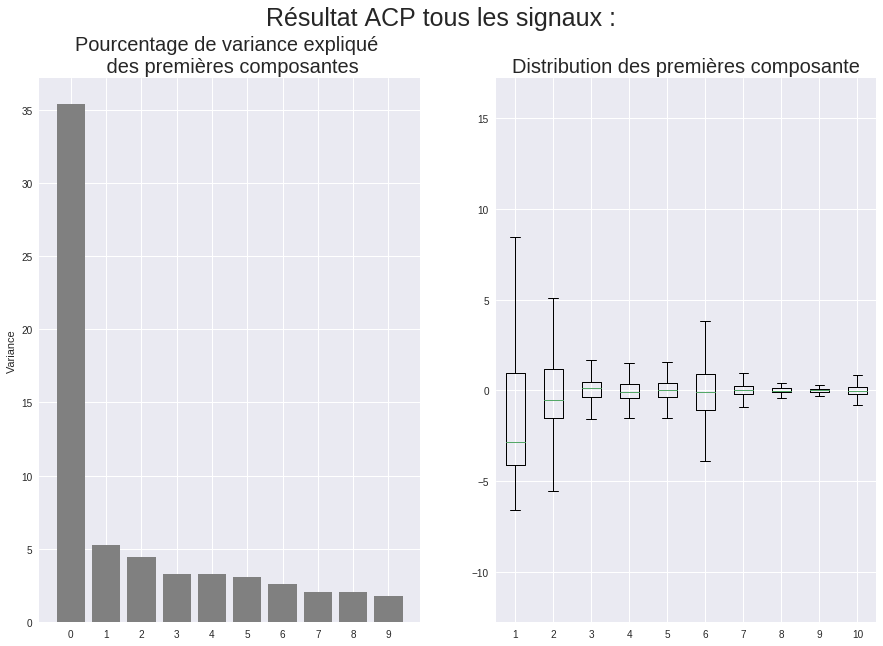

In [55]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title("Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_r[:,0:10])
ax.set_title("Distribution des premières composante", fontsize=20)

fig.suptitle("Résultat ACP tous les signaux : ", fontsize=25)

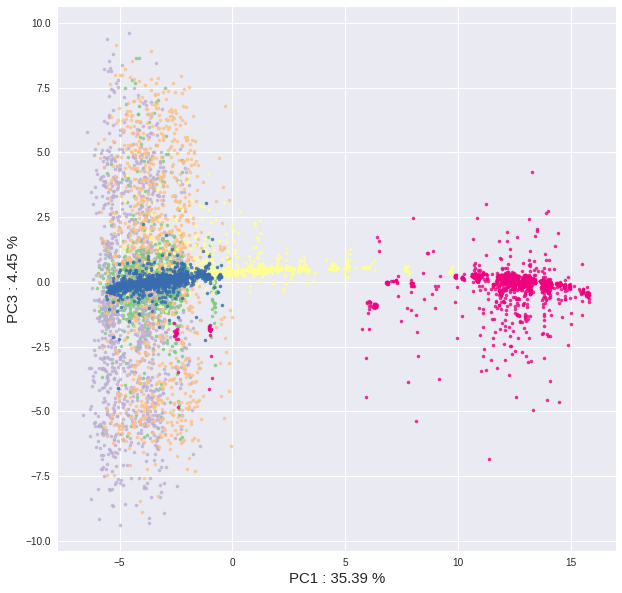

In [56]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_r, Y_train_label,fig ,ax ,1 ,3)

L'ACP sur les 9 séries temporelles donne de meilleurs résultats pour discriminer les classes passives et actives. Cependant, cela reste difficile de bien distinguer les 6 classes (en particulier les classes actives). 

## 5 Analyse factorielle discriminante

### 5.1 Sur un signal

LDA Sur signal : body_acc x


/usr/local/insa/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


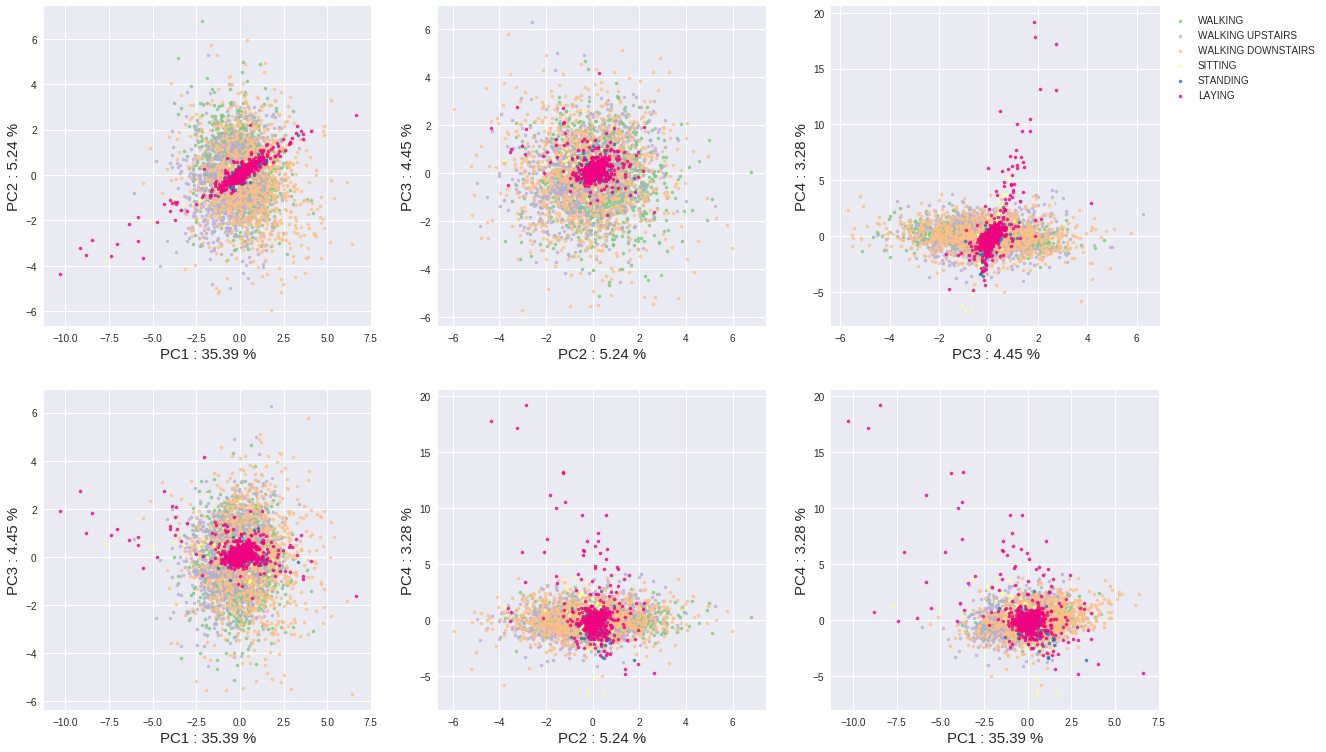

In [57]:
isignal = 0
signal = SIGNALS[isignal]
print("LDA Sur signal : " +signal)

method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(X_train[:,:,isignal],Y_train_label)
X_r2=lda.transform(X_train[:,:,isignal])

fig = plt.figure(figsize= (20,20))
count = 0
for count,(nbc, nbc2)in enumerate([(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]) :
    ax = fig.add_subplot(3,3,count+1)
    plot_pca(X_r2, Y_train_label , fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.2))
plt.show()

### 5.2  Sur tous les signaux

LDA Sur tous les signaux


/usr/local/insa/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


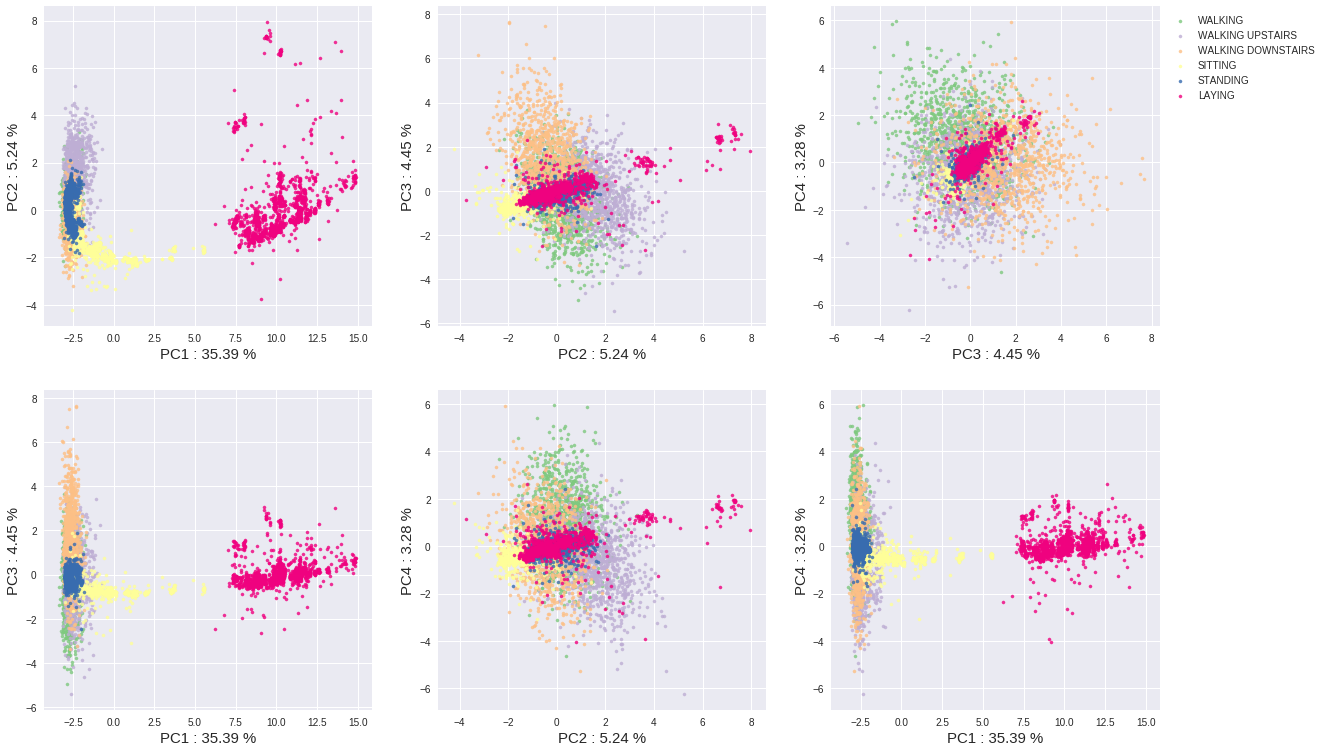

In [58]:
print("LDA Sur tous les signaux")

method = sda.LinearDiscriminantAnalysis() 
lda=method.fit(X_train_flatten,Y_train_label)
X_r2=lda.transform(X_train_flatten)

fig = plt.figure(figsize= (20,20))
count = 0
for count,(nbc, nbc2)in enumerate([(1,2), (2,3), (3,4), (1,3), (2,4), (1,4)]) :
    ax = fig.add_subplot(3,3,count+1)
    plot_pca(X_r2, Y_train_label , fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 2.2))
plt.show()

Mis à part la classe `laying`, aucun plan de l'ACP n'arrive à discriminer les activités avec les données brutes. Ceci est probablement dû au manque de prise en compte de la forme des signaux (périodicité, amplitude, translation). Les bases de Fourier et de Haar seraient peut-être plus adaptées. 

## 6. ACP sur les bases d'ondelettes de Haar

In [74]:
import pywt
from statsmodels.robust import mad
import sklearn.decomposition as sd

### 6.1 Avec un signal

#### Coefficients d'ondelettes

In [75]:
wf = "haar"

Coeff = []
TCoeff = []
for x in X_train[:,:,isignal]:
    #Apply wabvelet decomposition
    coeffs = pywt.wavedec(x,wf,level=7)
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(128))
    # Apply Threshold on 4 fist level
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(7352, 128) (7352, 128)
941056 210641


In [78]:
acp = sd.PCA()
X_acp = acp.fit_transform(sprep.scale(Coeff[:,64:]))

Text(0.5,1,'Distribution des premières composante')

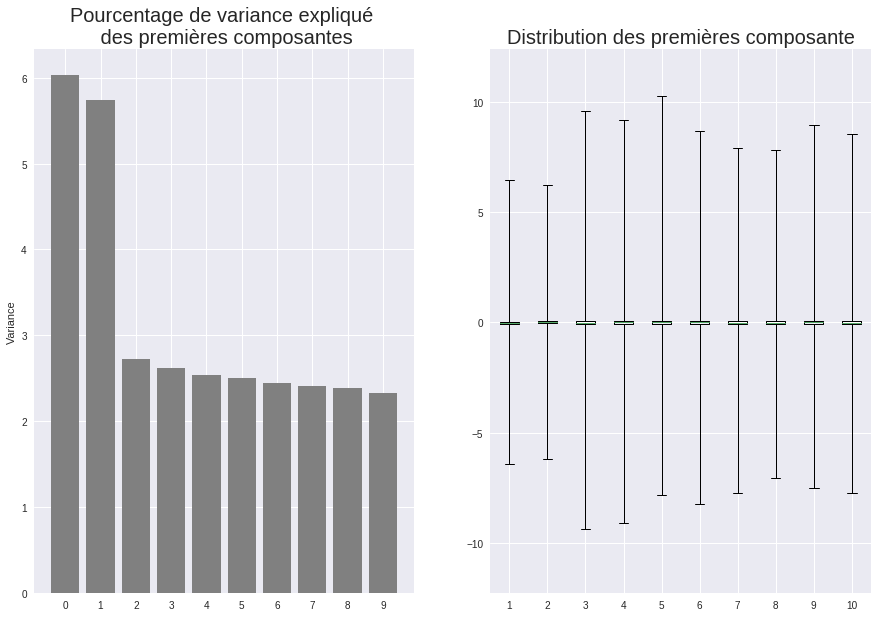

In [80]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp[:,0:10], whis=100)
ax.set_title("Distribution des premières composante", fontsize=20)


In [ ]:
COLOR_DIC= {1 : "green", 2: "purple", 3: "orange", 4: "yellow", 5:"blue", 6:"pink"}

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(7352)),  Y_train_label):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ACTIVITY_DIC[a]
        #ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
plt.legend(fontsize=10)
ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y in zip(acp.components_[0], acp.components_[1]):
    ax.plot(x,y,marker=".", color='red')
    #ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premières composantes", fontsize=20)

### 6.2 Avec tous les signaux 